/var/folders/zv/rfxft3f92_l_ch40bgx1qqpw0000gn/T/ipykernel_63556/984836692.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['rsi'] = rsi.rsi()


(6129, 8)
Feature 0: 27115584.832708
Feature 1: 28995559.820009
Feature 2: 12224233.267617
Feature 3: 1093.545251
Feature 4: 0.956695
Feature 5: 663282.064732
Feature 6: 1234265.675712


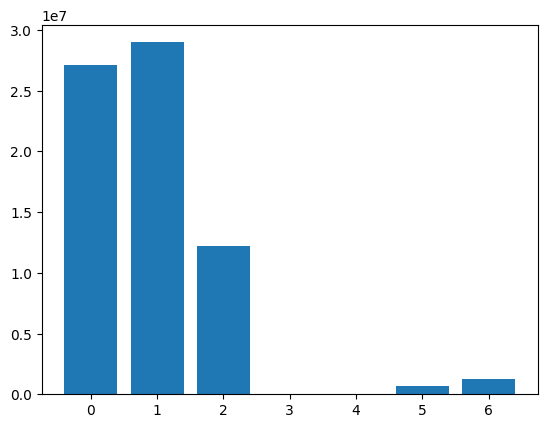

In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from ta.momentum import RSIIndicator
from ta.trend import IchimokuIndicator
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler

window_size = 30
batch_size = 128
stock_symbol = 'AAPL'
data = pd.read_csv(f'{stock_symbol}_historical_data.csv')
x = data[['High', 'Low', 'Close', 'Adj Close','Volume']]
rsi = RSIIndicator(close=x["Close"])
ichi = IchimokuIndicator(high=x["High"],low=x["Low"])
x['rsi'] = rsi.rsi()
x['ichi_b'] = ichi.ichimoku_b()
x['ichi_base'] = ichi.ichimoku_base_line()
'''
x['SMA_7'] = x['Close'].rolling(window=7).mean()
x['SMA_21'] = x['Close'].rolling(window=21).mean()
x['EMA_7'] = x['Close'].ewm(span=7, adjust=False).mean()
x['EMA_21'] = x['Close'].ewm(span=21, adjust=False).mean()
x['Momentum'] = x['Close'].diff(7)
mid = x['Close'].rolling(window=20).mean()
x['Upper_Band'] = mid + 2 * x['Close'].rolling(window=20).std()
x['Lower_Band'] = mid - 2 * x['Close'].rolling(window=20).std()
'''
x = x.dropna()
x = x.fillna(0)
x = x.values
'''
X_scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaler = MinMaxScaler(feature_range=(-1, 1))
t = np.concatenate((x[:,:2],x[:,3:]),axis=1)
m = np.reshape(x[:,2],(-1,1))
X_scaler.fit(t)
y_scaler.fit(m)
'''

scaler = MinMaxScaler()
x = scaler.fit_transform(x)
'''

rolling_mean = x.rolling(window=5, min_periods=1).mean()
rolling_std = x.rolling(window=5, min_periods=1).std()
# Normalize the data
x = (x - rolling_mean) / rolling_std
'''


print(x.shape)
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

def select_features(X_train, y_train, X_test):

 fs = SelectKBest(score_func=f_regression, k='all')

 fs.fit(X_train, y_train)

 X_train_fs = fs.transform(X_train)
 X_test_fs = fs.transform(X_test)
 return X_train_fs, X_test_fs, fs

yo = np.concatenate((x[:,:2],x[:,3:]),axis=1)
X_train, X_test, y_train, y_test = train_test_split(yo, x[:,2], test_size=0.33, random_state=1)
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
for i in range(len(fs.scores_)):
 print('Feature %d: %f' % (i, fs.scores_[i]))

plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

X, Y = [], []
for i in range(0, x.shape[0] - window_size - 1):
    X.append(np.array(x[i:i + window_size, :]))
    Y.append(np.array(x[i + window_size,2])) 
X = np.array(X)
Y = np.array(Y)
train_X,test_X,train_label,test_label = X[:-30],X[-30:],Y[:-30],Y[-30:]

train_X = torch.tensor(train_X,dtype=torch.float32)
test_X = torch.tensor(test_X,dtype=torch.float32)
train_label = torch.tensor(train_label,dtype = torch.float32)
test_label = torch.tensor(test_label,dtype=torch.float32)

train_label = torch.unsqueeze(train_label,dim=1)

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout, MultiHeadAttention, Flatten

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):

    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = x + inputs
    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return x + res

def build_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0):
    inputs = Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = Flatten()(x)
    for dim in mlp_units:
        x = Dense(dim, activation="relu")(x)
        x = Dropout(mlp_dropout)(x)
    outputs = Dense(1)(x)
    return Model(inputs, outputs)

input_shape = (30, 8) 
model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=256,
    num_transformer_blocks=8,
    mlp_units=[256, 128],
    dropout=0.1,
    mlp_dropout=0.1,
)

model.compile(loss="mean_squared_error", optimizer="adam")
model.summary()


history = model.fit(train_X, train_label, validation_data=(test_X, test_label), epochs=10, batch_size=32)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 30, 8)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 30, 8)     │         16 │ input_layer[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 30, 8)     │     35,848 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 30, 8)     │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 30, 8)     │          0 │ dropout_1[0][0],  │
│                     │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 8)     │         16 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 30, 256)   │      2,304 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 30, 256)   │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 30, 8)     │      2,056 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 30, 8)     │          0 │ dense_1[0][0],    │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 8)     │         16 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 30, 8)     │     35,848 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 30, 8)     │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 30, 8)     │          0 │ dropout_4[0][0],  │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 8)     │         16 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 30, 256)   │      2,304 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 30, 256)   │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 30, 8)     │      2,056 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 30, 8)     │          0 │ dense_3[0][0],    │
│                     │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 416,641 (1.59 MB)

 Trainable params: 416,641 (1.59 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 32s 137ms/step - loss: 0.1391 - val_loss: 0.0084
Epoch 2/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 25s 133ms/step - loss: 0.0046 - val_loss: 0.0619
Epoch 3/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 25s 130ms/step - loss: 0.0037 - val_loss: 0.0373
Epoch 4/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 25s 132ms/step - loss: 0.0025 - val_loss: 0.0190
Epoch 5/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 25s 129ms/step - loss: 0.0020 - val_loss: 0.0079
Epoch 6/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 26s 136ms/step - loss: 0.0019 - val_loss: 0.0201
Epoch 7/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 25s 129ms/step - loss: 0.0020 - val_loss: 0.0076
Epoch 8/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 25s 131ms/step - loss: 0.0022 - val_loss: 0.0210
Epoch 9/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - loss: 0.0016 - val_loss: 0.0523
Epoch 10/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 25s 130ms/step - loss: 0.0019 - val_loss: 6.8560e-04


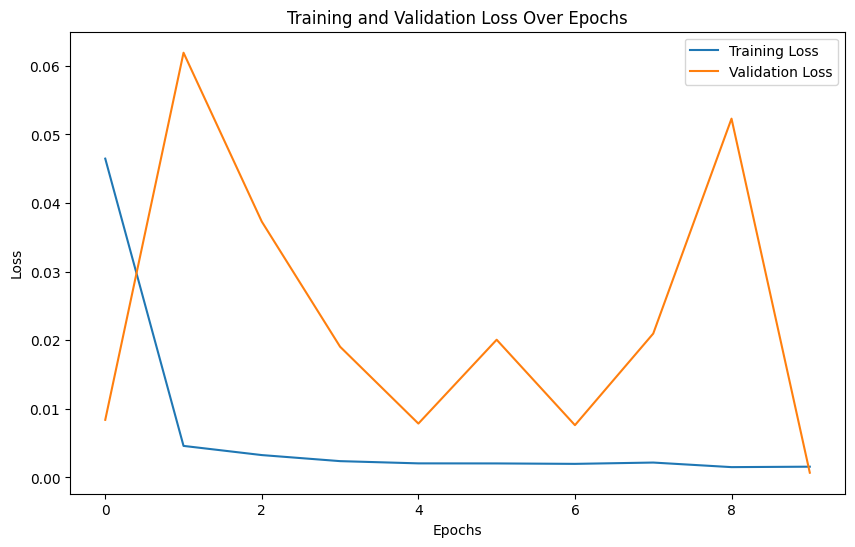

In [3]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

32.116479479361175


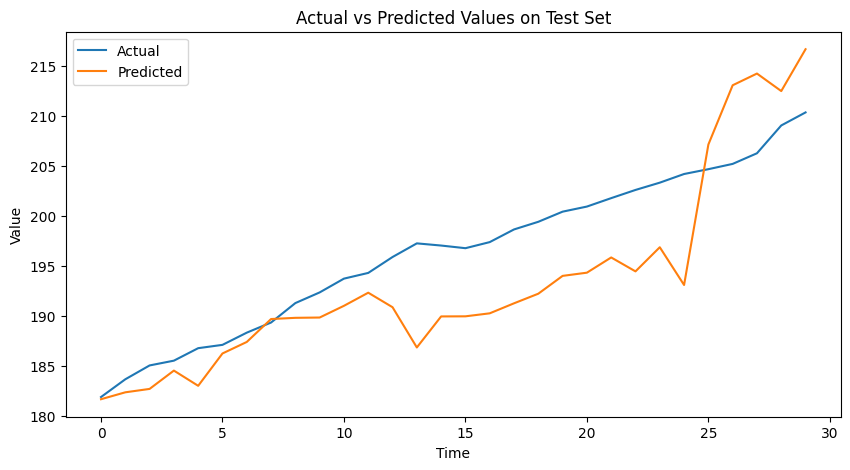

In [6]:
y_pred = model(test_X)
y_pred = np.squeeze(y_pred,axis=1)
y_pred_reshaped = np.zeros((y_pred.shape[0], x.shape[1])) 
y_pred_reshaped[:, 2] = y_pred 

test_label_reshaped = np.zeros((test_label.shape[0], x.shape[1]))
test_label_reshaped[:, 2] = test_label[:]

y_pred_inv = scaler.inverse_transform(y_pred_reshaped)[:, 2]
test_label_inv = scaler.inverse_transform(test_label_reshaped)[:, 2]
plt.figure(figsize=(10, 5))
plt.plot(y_pred_inv, label='Actual')
plt.plot(test_label_inv, label='Predicted')

test_label = np.array(test_label)
mse = np.mean((y_pred_inv - test_label_inv)**2)
print(mse)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values on Test Set')
plt.legend()
plt.show()